ValueError: x and y must be the same size

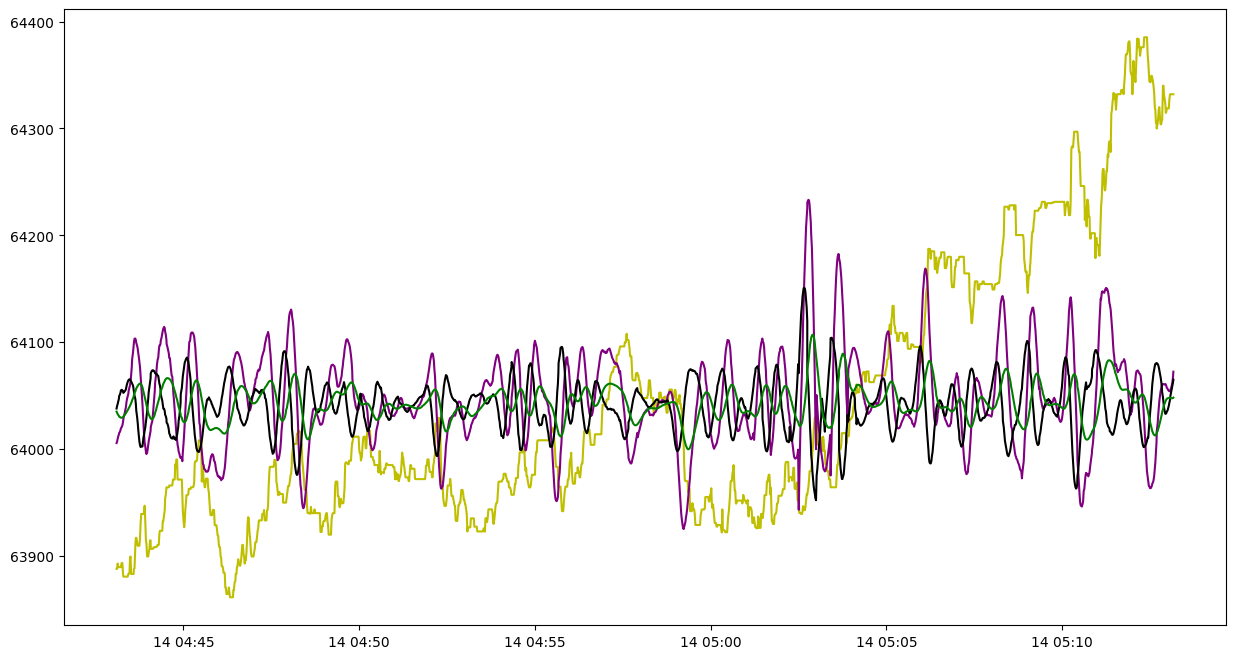

In [46]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client
from time import sleep
from IPython.display import clear_output

client = Client()

smooth_interval = 30
smooth_exp = 3
rango = 0
std_mult = 0.009
pdi_mult = 20
sdi_mult = 100
z_aprox = 0.05
pmax_idx = 0
pmin_idx = 0
time_max_points = [datetime.utcnow()]
time_min_points = [datetime.utcnow()]
price_max_points = []
price_min_points = []
k = 0

while True:
    clear_output(wait=True)

    recent_data = pd.read_csv('../../csvs/streaming/BTCUSDT.csv')
    recent_data.columns = ['Tiempo','Simbolo','Open']
    recent_data = recent_data.loc[:,['Tiempo','Open']]
    recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
    recent_data = recent_data.set_index('Tiempo')
    recent_data['Open'] = recent_data.Open.astype(float)
    recent_data = recent_data.reset_index()

    ##################################################
    # Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
    ##################################################
    recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,smooth_interval,3)
    recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,3)
    recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,3)
    recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)
    recent_data['Mpd']=recent_data['PD_Interpolacion'].rolling(window=15).mean()
    # recent_data['Msd']=recent_data['SD_Interpolacion'].rolling(window=30).mean()

    try:
        initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-60*30:-60*30 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
    except:
        initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-60*30:-60*30 + 1].item()),'%Y-%m-%d %H:%M:%S')].index.item() + rango
    try:
        final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango
    except:
        final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item() - rango

    lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index].TD_Interpolacion >= -z_aprox) & (recent_data[initial_date_index:final_date_index].TD_Interpolacion <= z_aprox)]
    indices_min_max = lista_min_max.index.tolist()

    max_points_idx = []
    min_points_idx = []
    pmin = 0
    pmax = 0            

    for PMSD in indices_min_max:
        if (recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0) & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() > 0) & (recent_data.Mpd[PMSD:PMSD+1].item()*8 > 0):# -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            if (abs(recent_data.SD_Interpolacion[PMSD]*10) > abs(np.std(recent_data.Open)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) > abs(np.std(recent_data.Open)*std_mult)):
                pmax = recent_data.SD_Interpolacion[PMSD]
            for i in range(rango+1):
                if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                    break
                elif ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult)) > abs(np.std(recent_data.Open)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) > abs(np.std(recent_data.Open)*std_mult)):
                    pmax_idx = PMSD-i
                elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult)) > abs(np.std(recent_data.Open)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) > abs(np.std(recent_data.Open)*std_mult)):
                    pmax_idx = PMSD+i
                if pmax_idx == 0:
                    pass
                else:
                    max_points_idx.append(pmax_idx)
        elif (recent_data.SD_Interpolacion[PMSD:PMSD+1].item() < 0) & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() < 0) & (recent_data.Mpd[PMSD:PMSD+1].item()*8 < 0):# abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            if (abs(recent_data.SD_Interpolacion[PMSD]*10) > abs(np.std(recent_data.Open)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) < -abs(np.std(recent_data.Open)*std_mult)):
                pmin = recent_data.SD_Interpolacion[PMSD]
            for i in range(rango+1):
                if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                    break
                elif ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult) > abs(np.std(recent_data.Open)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) < -abs(np.std(recent_data.Open)*std_mult)):
                    pmin_idx = PMSD-i
                elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult) > abs(np.std(recent_data.Open)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) < -abs(np.std(recent_data.Open)*std_mult)):
                    pmin_idx = PMSD+i
                if pmin_idx == 0:
                    pass
                else:
                    min_points_idx.append([pmin_idx])
    max_points_idx = list(set(max_points_idx))
    min_points_idx = list(set(min_points_idx))
    max_points_idx.sort()
    min_points_idx.sort()
    
    try:
        if recent_data.Tiempo[max_points_idx[-1]] == time_max_points[-1]:
            time_max_points.append(recent_data.Tiempo.iloc[max_points_idx[-1]])
            price_max_points.append(recent_data.Open.iloc[max_points_idx[-1]])
            k += 1
        if recent_data.Tiempo[min_points_idx[-1]] == time_min_points[-1:]:
            time_min_points.append(recent_data.Tiempo.iloc[min_points_idx[-1]])
            price_min_points.append(recent_data.Open.iloc[max_points_idx[-1]])
            k += 1
    except IndexError:
        print('sin indices')


    mp = recent_data.Open[initial_date_index:final_date_index].mean()
    plt.figure(figsize=(15,8))
    plt.plot(recent_data.Tiempo[initial_date_index - rango:final_date_index + rango],recent_data.Open[initial_date_index - rango:final_date_index + rango].multiply(1),color='y')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(pdi_mult)+mp,'purple')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(sdi_mult)+mp,color='k')
    # plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.TD_Interpolacion[initial_date_index:final_date_index].multiply(300)+mp,color='y')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Mpd[initial_date_index:final_date_index].multiply(8)+mp,color='g')
    # plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Msd[initial_date_index:final_date_index].multiply(500000)+mp,color='b')


    if k == 0:
        plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Open.iloc[max_points_idx],color='g')
        plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Open.iloc[min_points_idx],color='r')
    else:
        plt.scatter(time_max_points,price_max_points,color='g')
        plt.scatter(time_min_points,price_min_points,color='r') # recent_data[recent_data.Tiempo == time_min_points].index
    plt.grid(visible=True)

    # Set minor tick locations.
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
    plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=15))
    plt.gca().yaxis.set_major_locator(ticker.LinearLocator(40))
    plt.gcf().autofmt_xdate()

    # Set grid to use minor tick locations. 
    plt.grid(which = 'minor')
    plt.xticks(rotation=75)
    plt.axhline(mp)
    plt.axhline(np.std(recent_data.Open)*std_mult + mp)
    plt.axhline(mp - np.std(recent_data.Open)*std_mult)
    # plt.axvline(datetime.strptime('2024-04-04 09:59:00','%Y-%m-%d %H:%M:%S'))
    plt.show()
    # sleep(15)

In [37]:
time_max_points[-1]

IndexError: list index out of range

In [17]:
recent_data[-60*30:-60*30 + 1].Tiempo

88447   2024-04-14 04:08:35.351
Name: Tiempo, dtype: datetime64[ns]

In [30]:
for i in range(30*60):
    for j in time_max_points:
        if recent_data[-60*30:].Tiempo[max_points_idx[i]] == j:
            print(recent_data[-60*30:].Tiempo[max_points_idx[i]],j)

2024-04-14 04:09:55.798000 2024-04-14 04:09:55.798000
2024-04-14 04:09:56.787000 2024-04-14 04:09:56.787000
2024-04-14 04:09:57.813000 2024-04-14 04:09:57.813000
2024-04-14 04:09:58.788000 2024-04-14 04:09:58.788000
2024-04-14 04:09:59.813000 2024-04-14 04:09:59.813000
2024-04-14 04:10:00.771000 2024-04-14 04:10:00.771000
2024-04-14 04:10:01.778000 2024-04-14 04:10:01.778000
2024-04-14 04:10:03.068000 2024-04-14 04:10:03.068000
2024-04-14 04:10:04.065000 2024-04-14 04:10:04.065000
2024-04-14 04:10:04.943000 2024-04-14 04:10:04.943000
2024-04-14 04:10:05.619000 2024-04-14 04:10:05.619000
2024-04-14 04:10:07.072000 2024-04-14 04:10:07.072000
2024-04-14 04:12:30.775000 2024-04-14 04:12:30.775000
2024-04-14 04:12:31.642000 2024-04-14 04:12:31.642000
2024-04-14 04:15:35.337000 2024-04-14 04:15:35.337000
2024-04-14 04:15:36.246000 2024-04-14 04:15:36.246000
2024-04-14 04:15:37.624000 2024-04-14 04:15:37.624000
2024-04-14 04:15:38.554000 2024-04-14 04:15:38.554000
2024-04-14 04:15:39.619000 2

IndexError: list index out of range

In [24]:
time_min_points

88451   2024-04-14 04:08:39.535
88811   2024-04-14 04:14:41.064
88812   2024-04-14 04:14:42.137
88813   2024-04-14 04:14:43.179
88814   2024-04-14 04:14:44.153
88815   2024-04-14 04:14:45.007
88816   2024-04-14 04:14:46.170
88817   2024-04-14 04:14:46.814
88818   2024-04-14 04:14:48.242
89067   2024-04-14 04:18:57.850
89130   2024-04-14 04:20:01.245
89131   2024-04-14 04:20:01.785
89132   2024-04-14 04:20:03.067
89133   2024-04-14 04:20:04.217
89134   2024-04-14 04:20:05.142
89135   2024-04-14 04:20:06.229
89212   2024-04-14 04:21:23.386
89213   2024-04-14 04:21:24.270
89214   2024-04-14 04:21:25.389
89215   2024-04-14 04:21:26.359
89216   2024-04-14 04:21:27.395
89619   2024-04-14 04:28:11.237
89620   2024-04-14 04:28:12.248
89621   2024-04-14 04:28:13.242
89622   2024-04-14 04:28:14.099
89623   2024-04-14 04:28:15.224
89624   2024-04-14 04:28:16.144
89625   2024-04-14 04:28:16.907
89748   2024-04-14 04:30:20.597
89749   2024-04-14 04:30:21.581
89750   2024-04-14 04:30:22.394
89751   

In [34]:
recent_data[-60*30:].Tiempo[max_points_idx[0]]

Timestamp('2024-04-14 04:09:55.798000')

In [22]:
recent_data.Tiempo.iloc[time_min_points]

IndexError: positional indexers are out-of-bounds

In [13]:
time_min_points

88451   2024-04-14 04:08:39.535
88811   2024-04-14 04:14:41.064
88812   2024-04-14 04:14:42.137
88813   2024-04-14 04:14:43.179
88814   2024-04-14 04:14:44.153
88815   2024-04-14 04:14:45.007
88816   2024-04-14 04:14:46.170
88817   2024-04-14 04:14:46.814
88818   2024-04-14 04:14:48.242
89067   2024-04-14 04:18:57.850
89130   2024-04-14 04:20:01.245
89131   2024-04-14 04:20:01.785
89132   2024-04-14 04:20:03.067
89133   2024-04-14 04:20:04.217
89134   2024-04-14 04:20:05.142
89135   2024-04-14 04:20:06.229
89212   2024-04-14 04:21:23.386
89213   2024-04-14 04:21:24.270
89214   2024-04-14 04:21:25.389
89215   2024-04-14 04:21:26.359
89216   2024-04-14 04:21:27.395
89619   2024-04-14 04:28:11.237
89620   2024-04-14 04:28:12.248
89621   2024-04-14 04:28:13.242
89622   2024-04-14 04:28:14.099
89623   2024-04-14 04:28:15.224
89624   2024-04-14 04:28:16.144
89625   2024-04-14 04:28:16.907
89748   2024-04-14 04:30:20.597
89749   2024-04-14 04:30:21.581
89750   2024-04-14 04:30:22.394
89751   

In [15]:
min_points_idx

[88451,
 88811,
 88812,
 88813,
 88814,
 88815,
 88816,
 88817,
 88818,
 89067,
 89130,
 89131,
 89132,
 89133,
 89134,
 89135,
 89212,
 89213,
 89214,
 89215,
 89216,
 89619,
 89620,
 89621,
 89622,
 89623,
 89624,
 89625,
 89748,
 89749,
 89750,
 89751,
 89752,
 89753,
 89754,
 89755,
 89756,
 89880,
 89920,
 89972,
 89973,
 90021,
 90022,
 90023,
 90024,
 90190,
 90191,
 90192,
 90193,
 90194]

In [16]:
recent_data.Tiempo == time_min_points

ValueError: Can only compare identically-labeled Series objects